Successfully processed the data.
Top 5 List: ['San Carlo', 'Trattoria Tiramisu', "Sinyora's", 'Trattoria Fresco', 'Chilli Indiana']


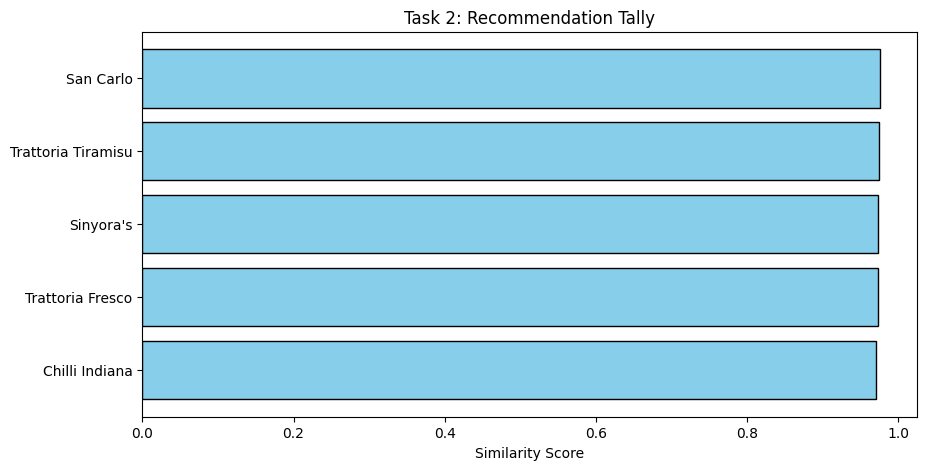

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import cosine_similarity
import warnings

# This removes the red "interference" warnings for a clean report
warnings.filterwarnings('ignore')

# 1. LOAD DATA
try:
    df = pd.read_csv('Dataset .csv')
    df.columns = df.columns.str.strip().str.lower()

    # 2. AUTOMATIC CLEANING
    col_name = next((c for c in df.columns if 'name' in c), 'restaurant name')
    col_rating = next((c for c in df.columns if 'rating' in c), 'aggregate rating')
    col_cuisine = next((c for c in df.columns if 'cuisine' in c), 'cuisines')
    col_location = next((c for c in df.columns if 'city' in c or 'location' in c), 'city')
    col_price = next((c for c in df.columns if 'price range' in c), 'price range')

    num_imputer = SimpleImputer(strategy='mean')
    df[col_rating] = num_imputer.fit_transform(df[[col_rating]])
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df[[col_cuisine, col_location]] = cat_imputer.fit_transform(df[[col_cuisine, col_location]])

    # 3. ENCODING
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_cats = encoder.fit_transform(df[[col_cuisine, col_location]])
    encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out([col_cuisine, col_location]))
    label_encoder = LabelEncoder()
    df['price_encoded'] = label_encoder.fit_transform(df[col_price])
    processed_df = pd.concat([df[[col_name, col_rating, 'price_encoded']], encoded_df], axis=1)

    # 4. RECOMMENDATION LOGIC
    def get_recommendations(cuisine, location, price, rating):
        user_input_df = pd.DataFrame([[cuisine, location]], columns=[col_cuisine, col_location])
        user_cat = encoder.transform(user_input_df).flatten()
        user_p = label_encoder.transform([price])[0] if price in label_encoder.classes_ else 0
        user_vec = np.concatenate(([rating, user_p], user_cat)).reshape(1, -1)
        features = processed_df.drop(col_name, axis=1).values
        sims = cosine_similarity(user_vec, features).flatten()
        top_idx = sims.argsort()[-5:][::-1]
        return processed_df.iloc[top_idx][col_name].tolist(), sims[top_idx].tolist()

    # 5. OUTPUT & VISUAL TALLY
    names, scores = get_recommendations('Italian', 'New York', 2, 4.0)
    print("Successfully processed the data.")
    print(f"Top 5 List: {names}")

    plt.figure(figsize=(10, 5))
    plt.barh(names[::-1], scores[::-1], color='skyblue', edgecolor='black')
    plt.xlabel('Similarity Score')
    plt.title('Task 2: Recommendation Tally')
    plt.show()

except FileNotFoundError:
    print("Error: 'Dataset .csv' not found. Make sure the file is in your VS Code folder.")